In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
cd gdrive/Shared drives/group5/numpy

/content/gdrive/Shared drives/group5/numpy


In [26]:
import os
from PIL import Image
import numpy as np
import pandas as pd
from sklearn import datasets, model_selection
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# load total trainset.
with np.load('./new_total_train_X.npz') as data:
    X_train_np = data['arr_0']

with np.load('./new_total_train_Y.npz') as data:
    Y_train_np = data['arr_0']

X_train = torch.from_numpy(X_train_np).float()
Y_train = torch.as_tensor(Y_train_np).long()
print(X_train.shape)
print(Y_train.shape)

train = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train, batch_size=64, shuffle=True)

torch.Size([16500, 3, 64, 64])
torch.Size([16500])


In [5]:
# load total validation set.
with np.load('./new_val_X.npz') as data:
    X_val = data['arr_0']

with np.load('./new_val_Y.npz') as data:
    Y_val = data['arr_0']


X_val = torch.as_tensor(X_val).float()
Y_val = torch.as_tensor(Y_val).long()

print(X_val.shape)
print(Y_val.shape)

val = TensorDataset(X_val, Y_val)
val_loader = DataLoader(val, batch_size=64, shuffle=True)

torch.Size([1650, 3, 64, 64])
torch.Size([1650])


In [6]:
# load total test set.
with np.load('./new_test_X.npz') as data:
    X_test = data['arr_0']

with np.load('./new_test_Y.npz') as data:
    Y_test = data['arr_0']

X_test = torch.as_tensor(X_test).float()
Y_test = torch.as_tensor(Y_test).long()

print(X_test.shape)
print(Y_test.shape)

test = TensorDataset(X_test, Y_test)
test_loader = DataLoader(test, batch_size=64, shuffle=True)


torch.Size([1644, 3, 64, 64])
torch.Size([1644])


In [7]:
#mini batch size
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

258
26
26


In [0]:
#gpu할당.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
#flatten
def flatten(x, start_dim=1, end_dim=-1):
  return x.flatten(start_dim=start_dim, end_dim=end_dim)

class Flatten(nn.Module):
  def forward(self, x):
    return flatten(x)


In [0]:
# 3 Layer CNN Model
class CNNClassifier(nn.Module):
    
    def __init__(self):
        # 항상 torch.nn.Module을 상속받고 시작
        super(CNNClassifier, self).__init__()

        conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size= 5, stride=1, padding=2) 
        # activation ReLU
        pool1 = nn.MaxPool2d(2) 
        conv2 = nn.Conv2d(in_channels= 10,out_channels= 20,kernel_size= 3, stride= 1,padding= 1) 
        # activation ReLU
        pool2 = nn.MaxPool2d(2) 
        fc1 = nn.Linear(20*16*16, 120)
        # activation ReLU
        fc2 = nn.Linear(120, 64)
        # activation ReLU
        fc3 = nn.Linear(64, 11)

      
        
        self.conv_module = nn.Sequential(
            conv1,
            nn.ReLU(),
            pool1,
            conv2,
            nn.ReLU(),
            pool2,

            Flatten(),
            fc1,
            nn.ReLU(),
            fc2,
            nn.ReLU(),
            fc3
        )
        

        # gpu로 할당
        self.conv_module = self.conv_module.to(device)
            
    def forward(self, x):
      scores= self.conv_module(x)
      return scores

#cnn model 인스턴스 
cnn = CNNClassifier()

In [0]:
# hyperparameter zone #
criterion = nn.CrossEntropyLoss()
#learning rate: 1e-1, 1e-2, 1e-3, 1e-4
l = 0.001
momentum = 0.5
#weight decay: 1e-4, 1e-5, 0
w=1e-4
optimizer = optim.Adam(cnn.parameters(), lr=l, betas=(0.9, 0.999), eps=1e-08, weight_decay= w, amsgrad=False)

In [0]:
dtype = torch.float
ltype = torch.long

In [24]:
#train test
train_loss_list = []
val_loss_list = []

for epoch in range(10):
    train_loss = 0.0
    for i, data in enumerate(train_loader,0):
      X_train, Y_train = data
      X_train, Y_train = X_train.to(device), Y_train.to(device)
      
      # grad init
      optimizer.zero_grad()
      # forward propagation
      model_output = cnn(X_train)
      # calculate loss
      loss = criterion(model_output, Y_train)
      #l2 regularization
      reg_lambda = 0.001
      l2_reg = 0.
      for param in cnn.parameters():
        l2_reg += param.norm(2)  
      loss = loss + reg_lambda * l2_reg          
      # back propagation 
      loss.backward()
      # weight update
      optimizer.step()        
      # train_loss summary
      train_loss += loss.item()
      # del (memory issue)
      del loss
      del model_output

    with torch.no_grad():
      val_loss = 0.0
      for i, val in enumerate(val_loader,0):
        X_val, Y_val = val
        X_val, Y_val = X_val.to(device), Y_val.to(device)
        val_output = cnn(X_val)
        v_loss = criterion(val_output, Y_val)
        val_loss += v_loss  
        del v_loss
        del val_output
        #l2 regularization
        reg_lambda = 0.001
        l2_reg = 0.
        for param in cnn.parameters():
          l2_reg += param.norm(2)  
        val_loss = val_loss + reg_lambda * l2_reg

    # print loss, val_loss
    j = len(train_loader)
    i = len(val_loader)
    print('[%d] loss: %.5f   val_loss: %.5f' %(epoch+1, train_loss/(j+1), val_loss/(i+1)))
    train_loss_list.append(train_loss/(j+1))
    val_loss_list.append(val_loss/(i+1))    

[1] loss: 1.65596   val_loss: 1.75590
[2] loss: 1.54870   val_loss: 1.73862
[3] loss: 1.41882   val_loss: 1.78262
[4] loss: 1.27887   val_loss: 1.87267
[5] loss: 1.13898   val_loss: 2.00158
[6] loss: 1.00663   val_loss: 2.04936
[7] loss: 0.89473   val_loss: 2.15098
[8] loss: 0.76708   val_loss: 2.33907
[9] loss: 0.66074   val_loss: 2.61782
[10] loss: 0.55729   val_loss: 2.75501


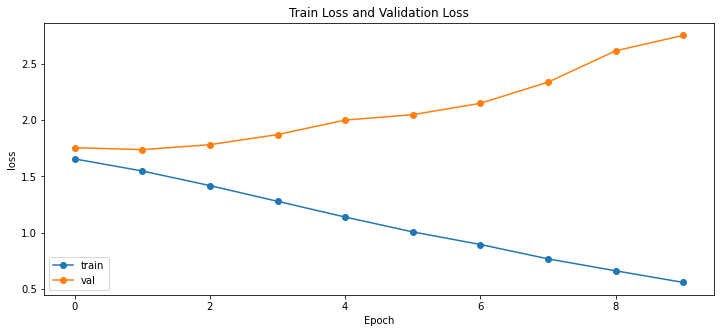

In [27]:
plt.title('Train Loss and Validation Loss')

plt.plot(train_loss_list, '-o', label='train')
plt.plot(val_loss_list, '-o', label='val')
plt.xlabel('Epoch')
plt.ylabel('loss')

plt.legend(loc='lower left')
plt.gcf().set_size_inches(12, 5)
plt.show()

In [0]:
#accuracy
classes = ('Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit')

A = np.zeros((11,11))

class_correct = list(0. for i in range(11))
class_total = list(0. for i in range(11))

X_test, Y_test = X_test.to(device), Y_test.to(device)

with torch.no_grad():
    for k, test in enumerate(test_loader,0):
      X_test, Y_test = test
      X_test, Y_test = X_test.to(device), Y_test.to(device) 
      outputs = cnn(X_test)
      _, predicted = torch.max(outputs, 1) # prediction
      c = (predicted == Y_test).squeeze()
      for i in range(len(predicted)):
        A[predicted[i]][Y_test[i]] += 1


In [30]:
classes = ('Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit')

total = np.zeros((11))
correct = np.zeros((11))
correct_total = 0

prob_class = np.zeros((11,11))

for i in range(11):
  for j in range(11):
   total[j] += A[i][j]
   class_total += total[j]

for i in range(11):
  correct[i] += A[i][i]
  correct_total += correct[i]

for i in range(11):
  for j in range(11):
    prob_class[i][j] = A[i][j] / total[j]

for i in range(11):
  print('Accuracy of %5s : %2d %%' % (classes[i], 100 * correct[i] / total[i]))

print('Total Accuracy: %2d %%' % (correct_total*100 / 1644))

Accuracy of Bread : 19 %
Accuracy of Dairy product : 24 %
Accuracy of Dessert : 33 %
Accuracy of   Egg : 32 %
Accuracy of Fried food : 46 %
Accuracy of  Meat : 31 %
Accuracy of Noodles-Pasta : 44 %
Accuracy of  Rice : 43 %
Accuracy of Seafood : 47 %
Accuracy of  Soup : 66 %
Accuracy of Vegetable-Fruit : 58 %
Total Accuracy: 40 %


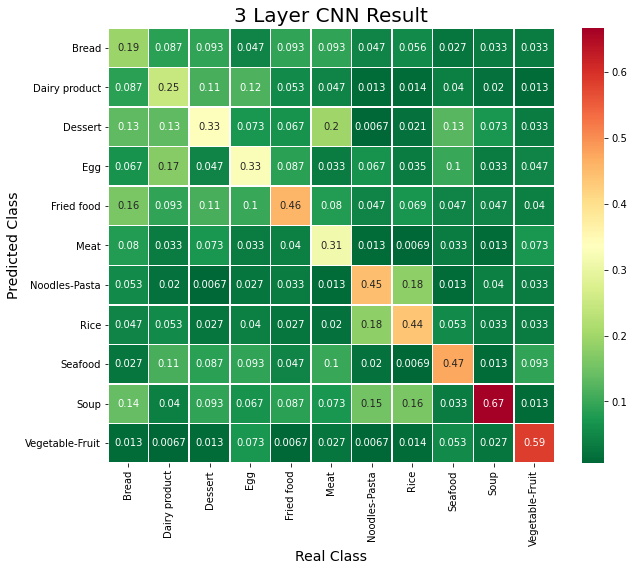

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

classes = ('Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit')

plt.figure(figsize = (10,8))
sns.heatmap(prob_class, xticklabels=classes, yticklabels=classes, annot=True, cmap='RdYlGn_r', linewidths=.5)
plt.title('3 Layer CNN Result', fontsize=20)
plt.xlabel('Real Class', fontsize=14)
plt.ylabel('Predicted Class', fontsize=14)

plt.show()